In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    density_reports = pd.read_excel("DensityReports.xlsx")
    product_attributes = pd.read_excel("ProductAttributes.xlsx")
    supplier_scorecard = pd.read_excel("SupplierScorecard.xlsx")
    historical_incidents = pd.read_excel("HistoricalIncidents.xlsx")
except FileNotFoundError as e:
    print(f"File not found: {e}")

Now we normalize/standardize labels in the documents

In [77]:
density_reports = pd.read_excel("DensityReports.xlsx")

# PackagingQuality
density_reports['PackagingQuality'] = density_reports['PackagingQuality'].str.strip().str.capitalize()
density_reports['PackagingQuality'] = density_reports['PackagingQuality'].replace({
    'Good': 'Good', 'GOOD': 'Good', 'good': 'Good', 'Bad': 'Bad', 'bad': 'Bad'
})
density_reports = density_reports[density_reports['PackagingQuality'].isin(['Good', 'Bad'])]

# SupplierName
density_reports['SupplierName'] = density_reports['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera" 
}

density_reports['SupplierName'] = density_reports['SupplierName'].replace(supplier_corrections)
density_reports['SupplierName'] = density_reports['SupplierName'].str.title() 

# Normalize ProposedFoldingMethod 
density_reports['ProposedFoldingMethod'] = density_reports['ProposedFoldingMethod'].str.replace('_', '', regex=False).str.strip().str.capitalize()

folding_correction = {
    "Methd1": "Method1",}
density_reports['ProposedFoldingMethod'] = density_reports['ProposedFoldingMethod'].replace(folding_correction)

# Normalize ProposedLayout 
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].str.strip().str.upper()

layout_corrections = {
    "LAYC": "LAYOUTC",
    "LAYOUTA": "LAYOUTA"
}
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].replace(layout_corrections)

valid_layouts = {'LAYOUTA', 'LAYOUTB', 'LAYOUTC', 'LAYOUTD', 'LAYOUTE'}
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].apply(lambda x: x if x in valid_layouts else 'LAYOUT_OTHER')


In [78]:
density_reports['ProposedFoldingMethod'].unique()


array(['Method2', 'Method1', 'Method3', nan, 'Foldx'], dtype=object)

In [79]:
historical_incidents = pd.read_excel("HistoricalIncidents.xlsx")

#SupplierName Cleaning
historical_incidents['SupplierName'] = historical_incidents['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera"
}

historical_incidents['SupplierName'] = historical_incidents['SupplierName'].replace(supplier_corrections)
historical_incidents['SupplierName'] = historical_incidents['SupplierName'].str.title()

In [80]:
supplier_scorecard = pd.read_excel("SupplierScorecard.xlsx")

#SupplierName Cleaning
supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera"
}

supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].replace(supplier_corrections)
supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].str.title()

Converting date columns to datetime objects (and moths to month format):

In [81]:
# Convert date columns to datetime objects
historical_incidents['DateOfIncident'] = pd.to_datetime(historical_incidents['DateOfIncident'])
density_reports['DateOfReport'] = pd.to_datetime(density_reports['DateOfReport'])
supplier_scorecard['Month'] = pd.to_datetime(supplier_scorecard['Month']).dt.to_period('M')


print(historical_incidents.info())
print(density_reports.info())
print(supplier_scorecard.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ProductReference  18000 non-null  object        
 1   SupplierName      18000 non-null  object        
 2   DateOfIncident    18000 non-null  datetime64[ns]
 3   IssueDescription  18000 non-null  object        
 4   ResolutionStatus  18000 non-null  object        
 5   CostImpact (€)    18000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 843.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 498137 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   ReportID                498137 non-null  object        
 1   ProductReference        498137 non-null  object        
 2   DateOfReport            498

Putting the entry values in descending order

In [82]:
density_reports = density_reports.sort_values(by='DateOfReport', ascending=False)
historical_incidents = historical_incidents.sort_values(by='DateOfIncident', ascending=False)
supplier_scorecard = supplier_scorecard.sort_values(by='Month', ascending=False)

Index(['ReportID', 'ProductReference', 'DateOfReport', 'SupplierName',
       'GarmentType', 'Material', 'Weight', 'ProposedUnitsPerCarton',
       'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality'],
      dtype='object')
Value Counts for SupplierName:
SupplierName
Suppliera    141420
Supplierb    111891
Supplierc     75933
Supplierd     53213
Suppliere     40513
Supplierf     34374
Supplierg     25423
Supplierh     15370
Name: count, dtype: int64



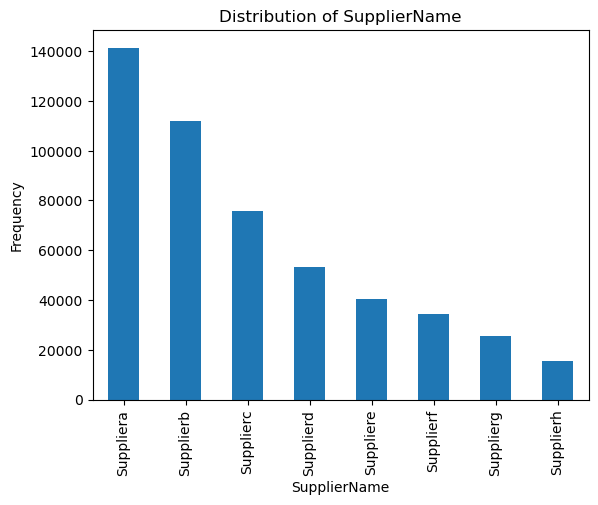

Value Counts for GarmentType:
GarmentType
Shirt      101422
Pants       75250
Jacket      51282
T-Shirt     48156
Dress       40703
Skirt       40575
Suit        29906
Shorts      26210
Coat        24509
Sweater     23529
Blouse      23392
Hoodie      13203
Name: count, dtype: int64



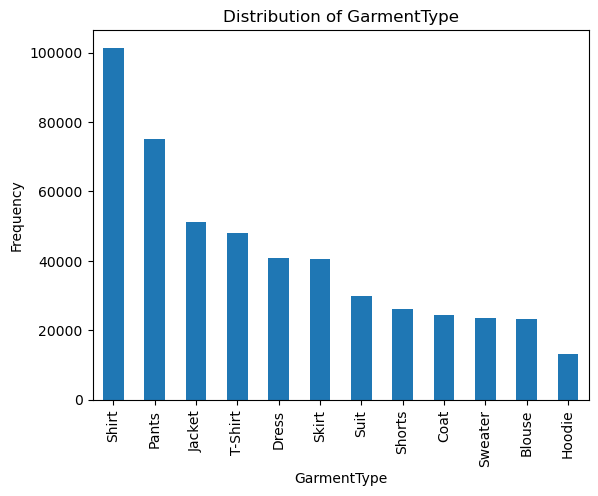

Value Counts for Material:
Material
Cotton       196262
Polyester    124787
Linen         50105
Wool          49182
Silk          41731
Denim         36070
Name: count, dtype: int64



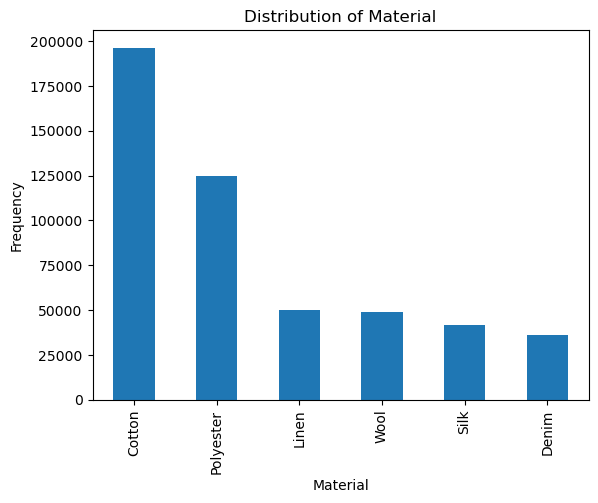

Value Counts for PackagingQuality:
PackagingQuality
Good    399252
Bad      98885
Name: count, dtype: int64



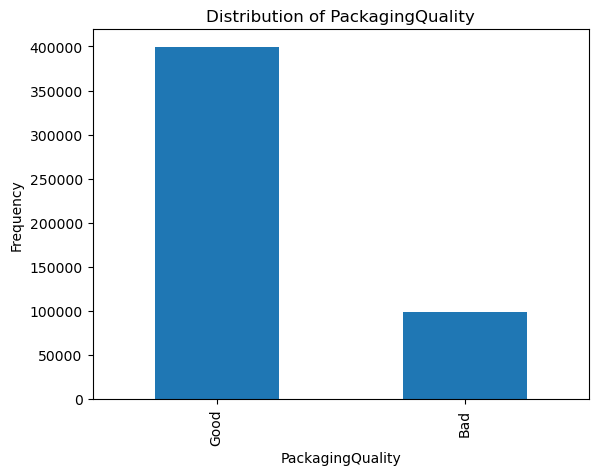

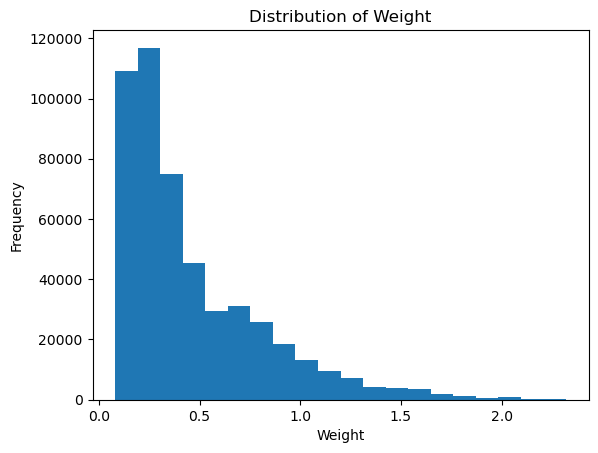

Summary statistics for Weight:
count    498137.000000
mean          0.460995
std           0.349701
min           0.080000
25%           0.210000
50%           0.330000
75%           0.620000
max           2.320000
Name: Weight, dtype: float64



In [83]:
print(density_reports.columns)

density_reports_numerical_cols = ['Weight', 'UnitsPerCarton']
density_reports_categorical_cols = ['SupplierName', 'GarmentType', 'Material', 'FoldingMethod', 'BoxLayout', 'PackagingQuality'] 

for col in density_reports_categorical_cols:
    if col in density_reports.columns:
        value_counts = density_reports[col].value_counts()
        print(f"Value Counts for {col}:\n{value_counts}\n")
        value_counts.plot(kind='bar', title=f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Warning: Column '{col}' not found in density_reports.")


for col in density_reports_numerical_cols:
    if col in density_reports.columns:
        plt.hist(density_reports[col], bins=20)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        stats = density_reports[col].describe()
        print(f"Summary statistics for {col}:\n{stats}\n")
    else:
        print(f"Warning: Column '{col}' not found in density_reports.")

Value Counts for GarmentType:
GarmentType
Shirt      2043
Pants      1512
Jacket     1027
T-Shirt     969
Skirt       816
Dress       811
Suit        598
Shorts      522
Coat        497
Sweater     472
Blouse      469
Hoodie      264
Name: count, dtype: int64



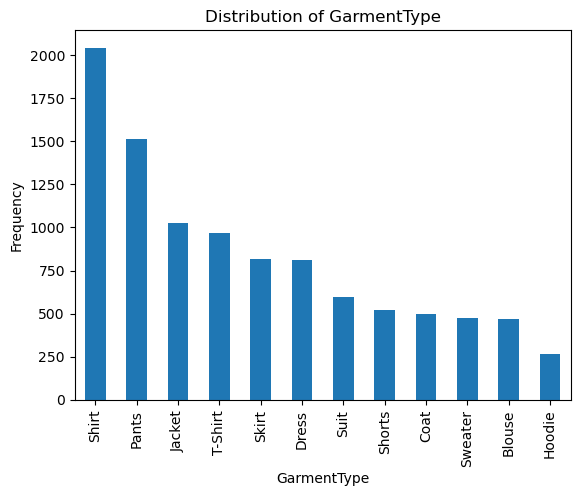

Value Counts for Material:
Material
Cotton       3926
Polyester    2512
Linen        1006
Wool          990
Silk          840
Denim         726
Name: count, dtype: int64



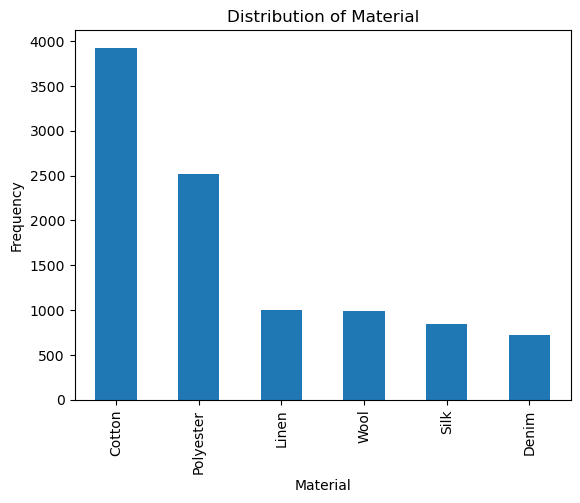

Value Counts for Size:
Size
M     3508
L     3039
S     1983
XL     988
XS     482
Name: count, dtype: int64



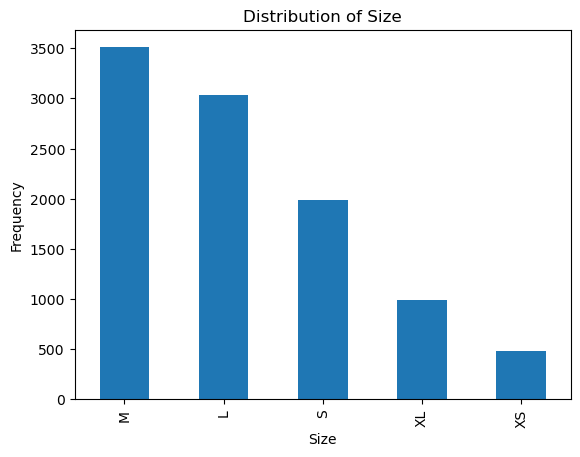

Value Counts for Collection:
Collection
Summer    3113
Winter    2897
Spring    2222
Autumn    1768
Name: count, dtype: int64



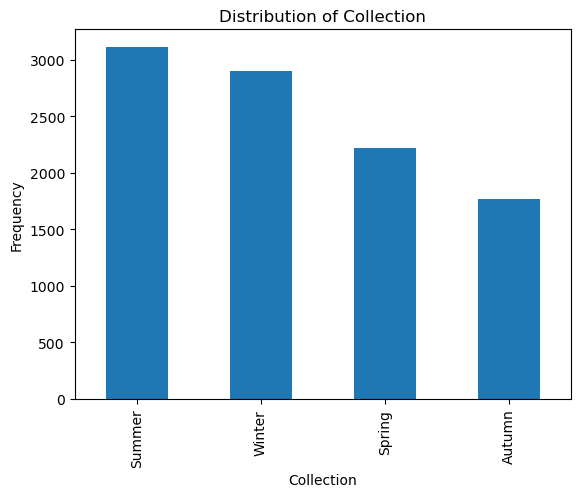

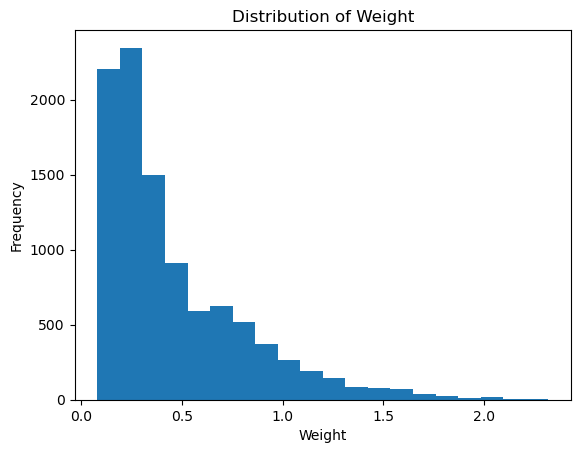

Summary statistics for Weight:
count    10000.000000
mean         0.461065
std          0.350351
min          0.080000
25%          0.200000
50%          0.330000
75%          0.620000
max          2.320000
Name: Weight, dtype: float64



In [84]:
product_attributes_numerical_cols = ['Weight']
product_attributes_categorical_cols = ['GarmentType', 'Material', 'Size', 'Collection']

for col in product_attributes_categorical_cols:
    value_counts = product_attributes[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in product_attributes_numerical_cols:
        plt.hist(product_attributes[col], bins=20)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        stats = product_attributes[col].describe()
        print(f"Summary statistics for {col}:\n{stats}\n")

Value Counts for SupplierName:
SupplierName
Suppliera    54
Supplierf    36
Supplierb    36
Supplierh    36
Supplierc    36
Supplierd    18
Supplierg    18
Suppliere    18
Name: count, dtype: int64



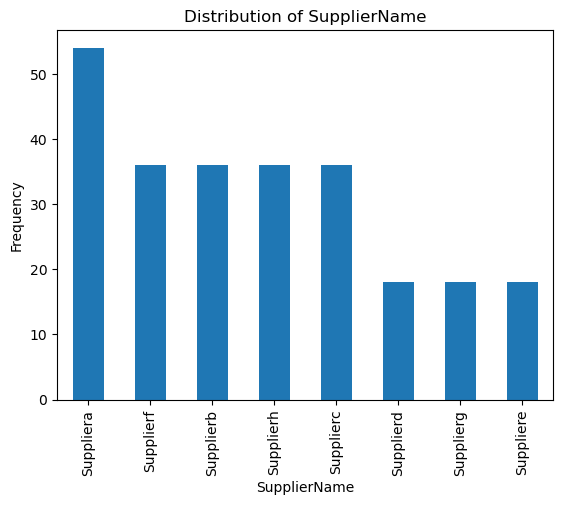

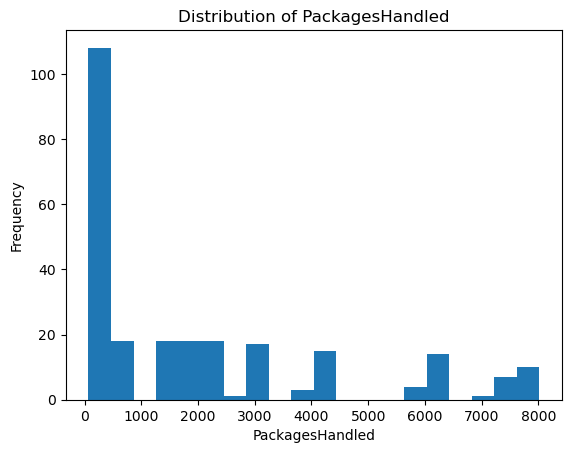

Summary statistics for PackagesHandled:
count     252.000000
mean     1984.126984
std      2382.575890
min        66.000000
25%        95.000000
50%      1097.000000
75%      2963.750000
max      8019.000000
Name: PackagesHandled, dtype: float64



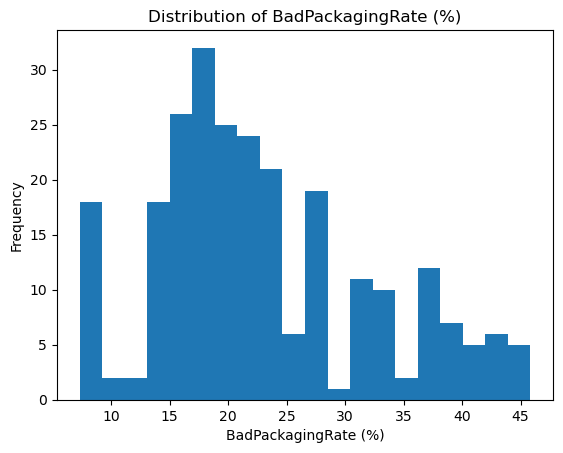

Summary statistics for BadPackagingRate (%):
count    252.000000
mean      23.047540
std        9.242888
min        7.290000
25%       16.652500
50%       21.000000
75%       27.510000
max       45.850000
Name: BadPackagingRate (%), dtype: float64



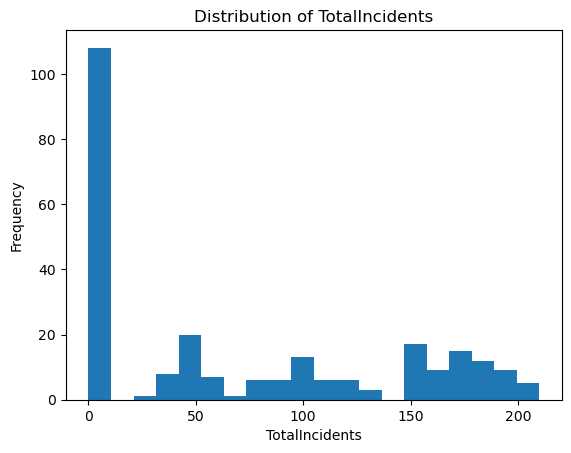

Summary statistics for TotalIncidents:
count    252.000000
mean      70.436508
std       71.666892
min        0.000000
25%        3.000000
50%       46.000000
75%      149.250000
max      210.000000
Name: TotalIncidents, dtype: float64



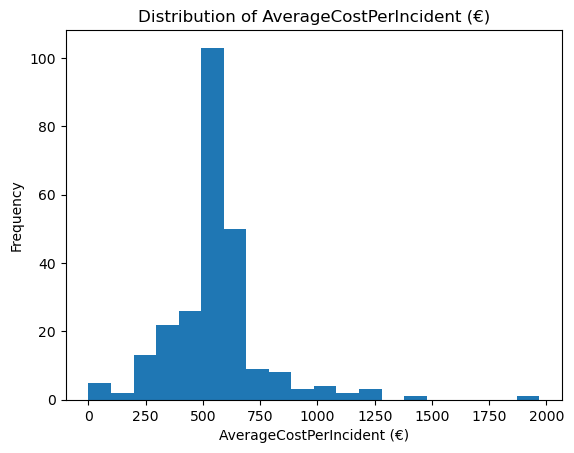

Summary statistics for AverageCostPerIncident (€):
count     252.000000
mean      552.654524
std       215.370064
min         0.000000
25%       483.457500
50%       544.090000
75%       611.607500
max      1969.000000
Name: AverageCostPerIncident (€), dtype: float64



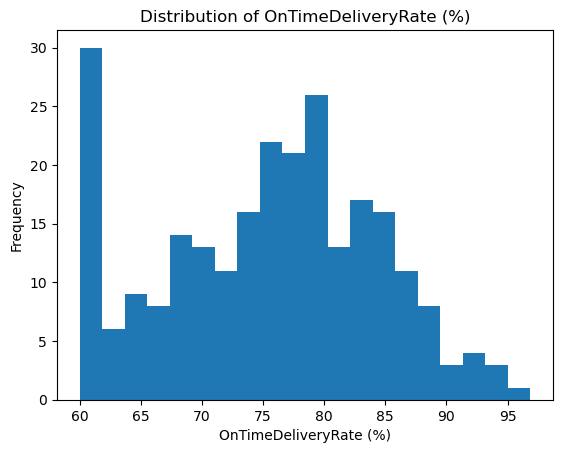

Summary statistics for OnTimeDeliveryRate (%):
count    252.000000
mean      75.397857
std        8.923621
min       60.000000
25%       68.837500
50%       76.395000
75%       81.950000
max       96.870000
Name: OnTimeDeliveryRate (%), dtype: float64



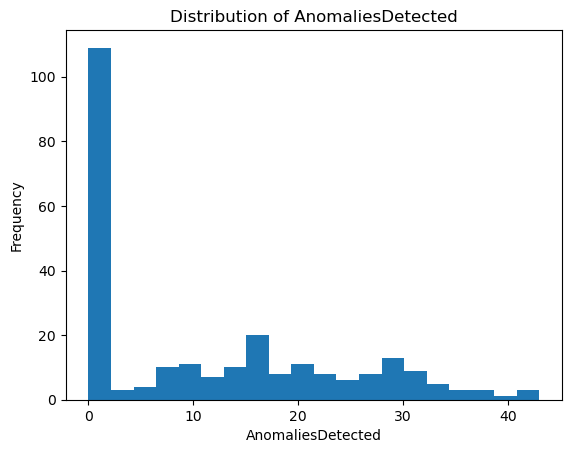

Summary statistics for AnomaliesDetected:
count    252.000000
mean      11.698413
std       12.036644
min        0.000000
25%        1.000000
50%        8.500000
75%       20.250000
max       43.000000
Name: AnomaliesDetected, dtype: float64



In [85]:
supplier_scorecard_numerical_cols = ['PackagesHandled', 'BadPackagingRate (%)', 'TotalIncidents', 'AverageCostPerIncident (€)', 'OnTimeDeliveryRate (%)', 'AnomaliesDetected']
supplier_scorecard_categorical_cols = ['SupplierName']

for col in supplier_scorecard_categorical_cols:
    value_counts = supplier_scorecard[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in supplier_scorecard_numerical_cols:
    plt.hist(supplier_scorecard[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    stats = supplier_scorecard[col].describe()
    print(f"Summary statistics for {col}:\n{stats}\n")

Value Counts for SupplierName:
SupplierName
Supplierc    3382
Supplierb    3356
Suppliera    3149
Supplierd    2758
Supplierf    1966
Suppliere    1627
Supplierh     937
Supplierg     825
Name: count, dtype: int64



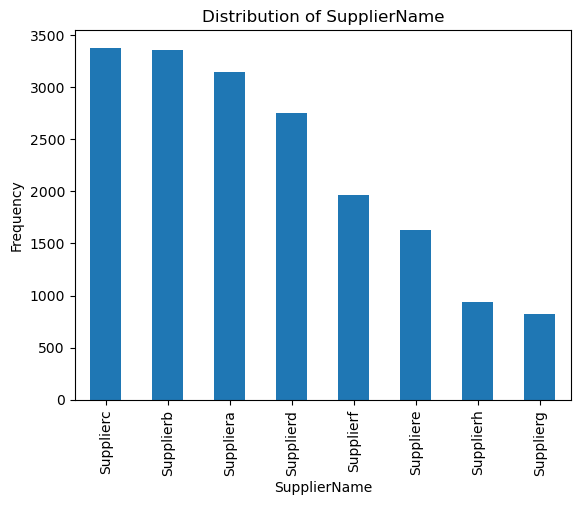

Value Counts for IssueDescription:
IssueDescription
Other                    5271
Labeling Error           4404
Packaging Damage         3454
Incorrect Folding        3243
Missing Items            1414
Transportation Damage     145
Product Wrinkled           69
Name: count, dtype: int64



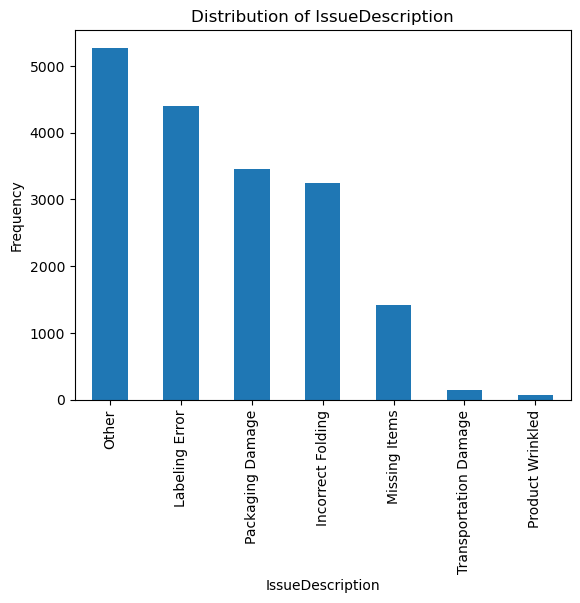

Value Counts for ResolutionStatus:
ResolutionStatus
Resolved        12538
In Progress      3617
Not Resolved     1845
Name: count, dtype: int64



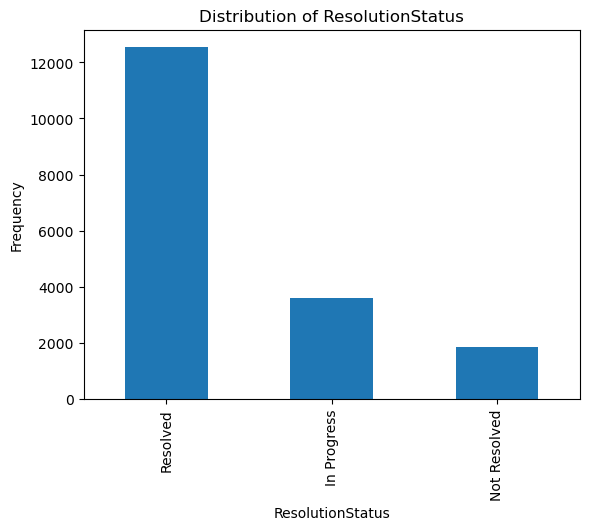

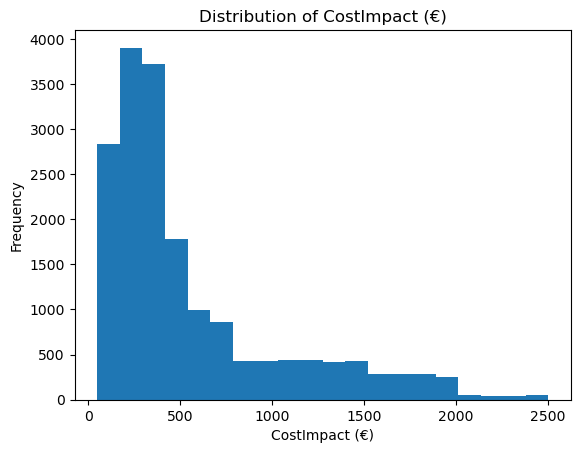

Summary statistics for CostImpact (€):
count    18000.000000
mean       555.215833
std        492.948178
min         50.000000
25%        224.000000
50%        365.000000
75%        693.750000
max       2500.000000
Name: CostImpact (€), dtype: float64



In [86]:
historical_incidents_numerical_cols = ['CostImpact (€)']
historical_incidents_categorical_cols = ['SupplierName', 'IssueDescription', 'ResolutionStatus']

for col in historical_incidents_categorical_cols:
    value_counts = historical_incidents[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in historical_incidents_numerical_cols:
    plt.hist(historical_incidents[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    stats = historical_incidents[col].describe()
    print(f"Summary statistics for {col}:\n{stats}\n")

In [87]:
density_reports_product_attributes_merged = pd.merge(density_reports, product_attributes, on='ProductReference', how='left')

DuplicateColumns = ['GarmentType_y', 'Material_y','Weight_y']
density_reports_product_attributes_merged.drop(DuplicateColumns, axis=1, inplace=True)

# Rename columns for clarity
density_reports_product_attributes_merged.rename(columns={'Material_x': 'Material',
                                                         'GarmentType_x': 'GarmentType',
                                                         'Weight_x': 'Weight'}, inplace=True)

print("Columns in merged DataFrame:", density_reports_product_attributes_merged.columns)

Columns in merged DataFrame: Index(['ReportID', 'ProductReference', 'DateOfReport', 'SupplierName',
       'GarmentType', 'Material', 'Weight', 'ProposedUnitsPerCarton',
       'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality',
       'ProductName', 'Size', 'Collection'],
      dtype='object')


packaging quality for SupplierName:
SupplierName      Suppliera  Supplierb  Supplierc  Supplierd  Suppliere  \
PackagingQuality                                                          
Bad                   11682      16728      20723      17262       9198   
Good                 129738      95163      55210      35951      31315   

SupplierName      Supplierf  Supplierg  Supplierh  
PackagingQuality                                   
Bad                   12642       4469       6181  
Good                  21732      20954       9189  



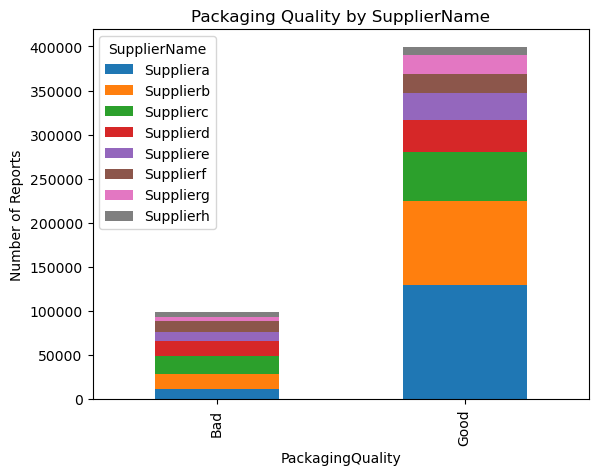

packaging quality for GarmentType:
GarmentType       Blouse   Coat  Dress  Hoodie  Jacket  Pants  Shirt  Shorts  \
PackagingQuality                                                               
Bad                 4560   6617   7648    2863   10149  14332  19433    4982   
Good               18832  17892  33055   10340   41133  60918  81989   21228   

GarmentType       Skirt   Suit  Sweater  T-Shirt  
PackagingQuality                                  
Bad                7719   6764     4533     9285  
Good              32856  23142    18996    38871  



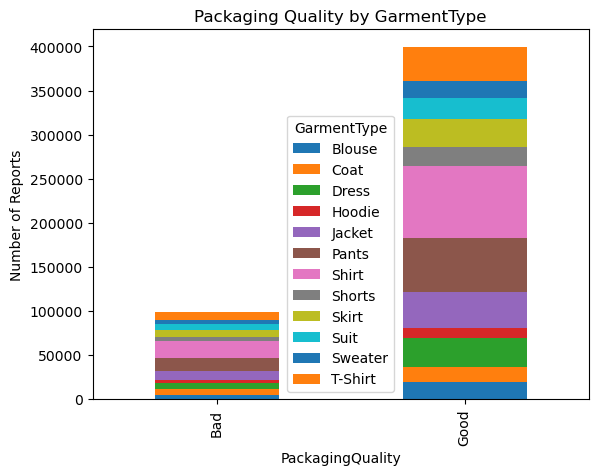

packaging quality for Material:
Material          Cotton  Denim  Linen  Polyester   Silk   Wool
PackagingQuality                                               
Bad                35571   6813   8856      21995  11521  14129
Good              160691  29257  41249     102792  30210  35053



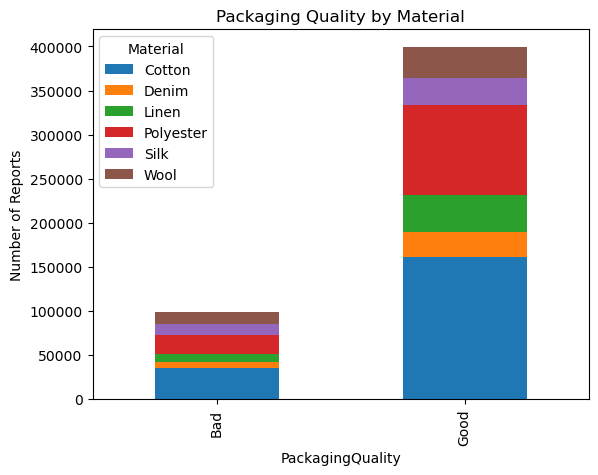

packaging quality for ProposedFoldingMethod:
ProposedFoldingMethod  Foldx  Method1  Method2  Method3
PackagingQuality                                       
Bad                      476    28757    39645    29533
Good                    1944   130746   180125    84405



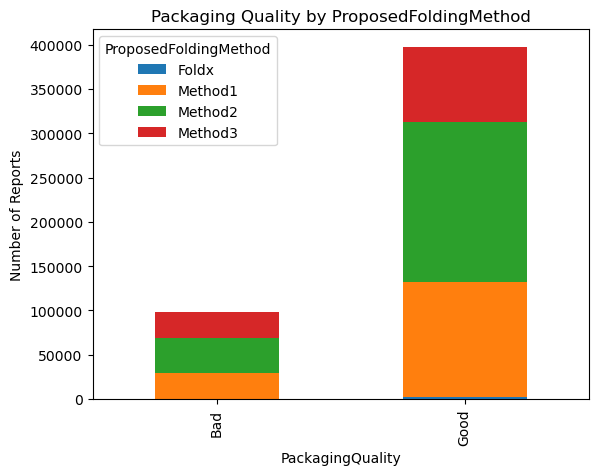

packaging quality for ProposedLayout:
ProposedLayout    LAYOUTA  LAYOUTB  LAYOUTC  LAYOUTD  LAYOUTE  LAYOUT_OTHER
PackagingQuality                                                           
Bad                 16505    34598    26936    13914     5936           996
Good                69744   145078   114370    50525    15415          4120



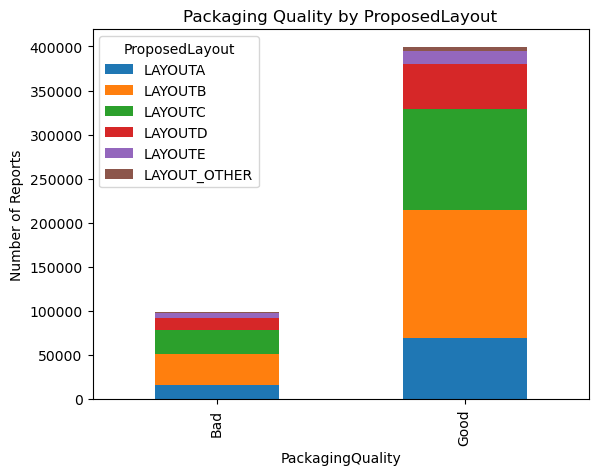

packaging quality for PackagingQuality:
PackagingQuality    Bad    Good
PackagingQuality               
Bad               98885       0
Good                  0  399252



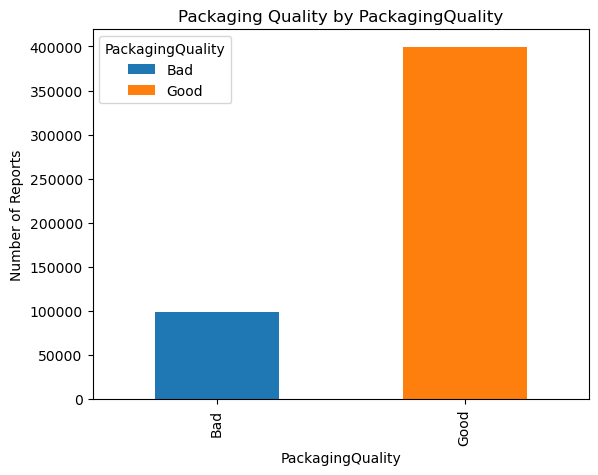

packaging quality for ProductName:
ProductName       Blouse Cotton L  Blouse Cotton M  Blouse Cotton S  \
PackagingQuality                                                      
Bad                           572              500              403   
Good                         2555             2327             1925   

ProductName       Blouse Cotton XL  Blouse Cotton XS  Blouse Denim L  \
PackagingQuality                                                       
Bad                            152                39              75   
Good                           756               233             374   

ProductName       Blouse Denim M  Blouse Denim S  Blouse Denim XL  \
PackagingQuality                                                    
Bad                           37              34               19   
Good                         236             192               73   

ProductName       Blouse Denim XS  ...  T-Shirt Silk L  T-Shirt Silk M  \
PackagingQuality                   ...  

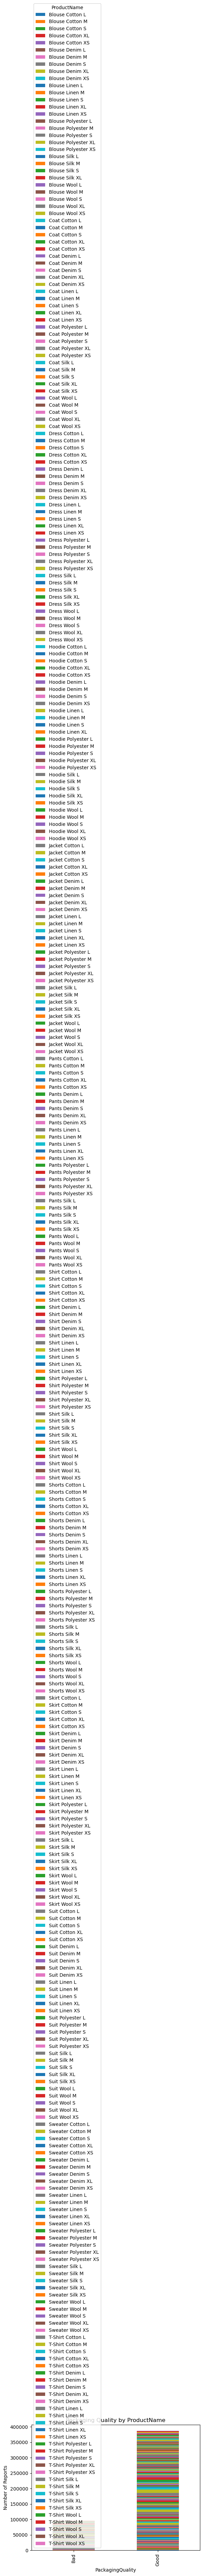

packaging quality for Size:
Size                   L       M      S     XL     XS
PackagingQuality                                     
Bad                28945   33629  19026   9665   4612
Good              117797  135553  76566  38139  18899



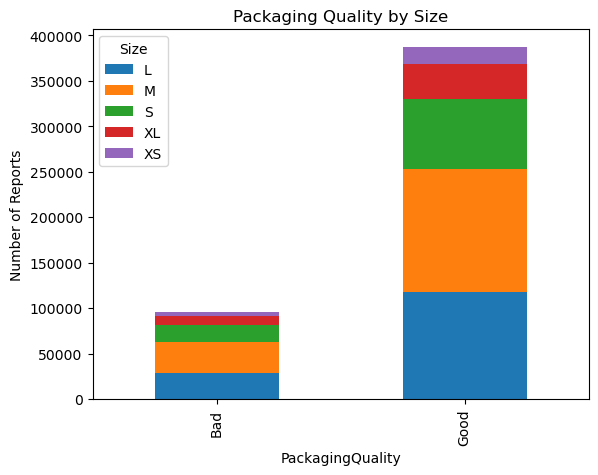

packaging quality for Collection:
Collection        Autumn  Spring  Summer  Winter
PackagingQuality                                
Bad                16793   21308   29785   27991
Good               68279   86332  120574  111769



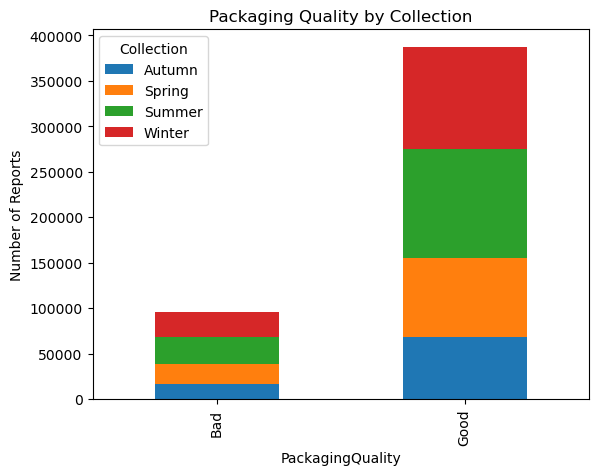

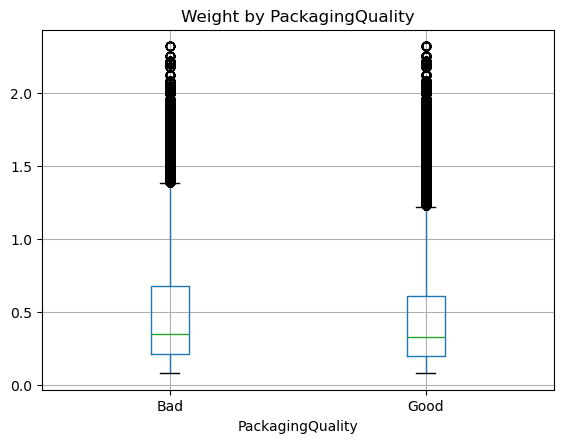

T-test P value : 5.957077837382592e-213


In [121]:
density_reports_categorical_cols_merged = ['SupplierName', 'GarmentType', 'Material', 'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality','ProductName','Size','Collection']

for col in density_reports_categorical_cols_merged:
    if col in density_reports_product_attributes_merged.columns:
        cross_tab = pd.crosstab(density_reports_product_attributes_merged['PackagingQuality'], density_reports_product_attributes_merged[col])
        print(f"packaging quality for {col}:\n{cross_tab}\n")
        cross_tab.plot(kind='bar', stacked=True)
        plt.title(f'Packaging Quality by {col}')
        plt.ylabel('Number of Reports')
        plt.show()
    else:
        print(f"Warning: Column '{col}' not found in merged DataFrame.")

density_reports_product_attributes_merged.boxplot(column='Weight', by='PackagingQuality')
plt.title('Weight by PackagingQuality')
plt.suptitle("")
plt.show()

from scipy import stats
group0 = density_reports_product_attributes_merged[density_reports_product_attributes_merged["PackagingQuality"]=="Good"]["Weight"]
group1 = density_reports_product_attributes_merged[density_reports_product_attributes_merged["PackagingQuality"]=="Bad"]["Weight"]
result = stats.ttest_ind(group0, group1) #t-test
print(f"T-test P value : {result.pvalue}")

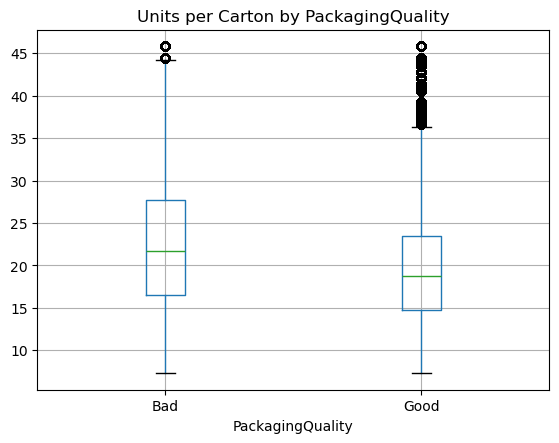

T-test P value : 0.0


In [125]:
density_reports_supplier_scorecard_merged = pd.merge(density_reports, supplier_scorecard, on='SupplierName', how='left')

density_reports_supplier_scorecard_merged.boxplot(column='BadPackagingRate (%)', by='PackagingQuality')
plt.title('Units per Carton by PackagingQuality')
plt.suptitle("")
plt.show()

from scipy import stats
group0 = density_reports_supplier_scorecard_merged[density_reports_supplier_scorecard_merged["PackagingQuality"]=="Good"]["BadPackagingRate (%)"]
group1 = density_reports_supplier_scorecard_merged[density_reports_supplier_scorecard_merged["PackagingQuality"]=="Bad"]["BadPackagingRate (%)"]
result = stats.ttest_ind(group0, group1)
print(f"T-test P value : {result.pvalue}")


/var/folders/kw/h652ds_j33g70dcfgpx2ldgr0000gn/T/ipykernel_5644/719905373.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = density_reports.set_index('DateOfReport').resample('M')['PackagingQuality'].value_counts().unstack()


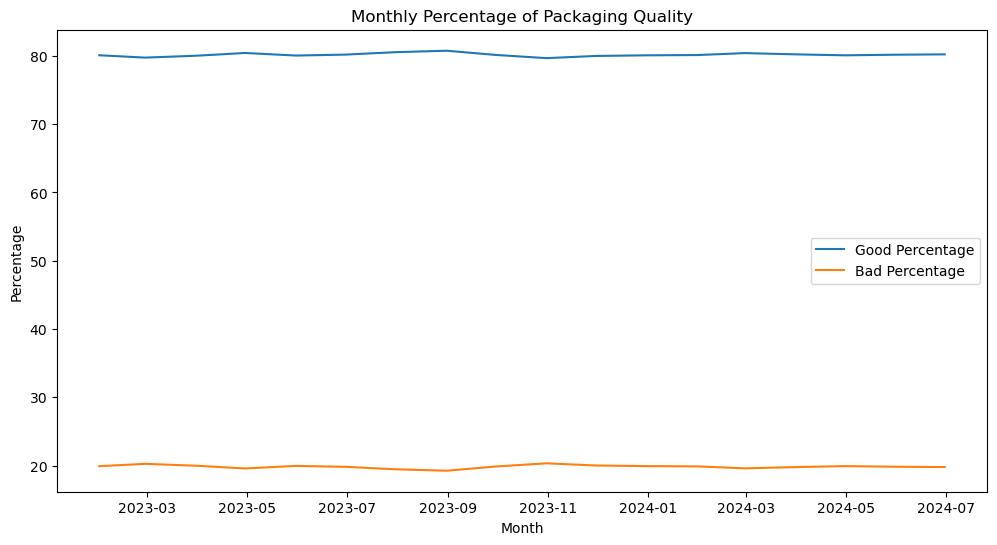

In [126]:
monthly_data = density_reports.set_index('DateOfReport').resample('M')['PackagingQuality'].value_counts().unstack()

monthly_data['Total'] = monthly_data['Good'] + monthly_data['Bad']
monthly_data['Good_Percentage'] = (monthly_data['Good'] / monthly_data['Total']) * 100
monthly_data['Bad_Percentage'] = (monthly_data['Bad'] / monthly_data['Total']) * 100

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Good_Percentage'], label='Good Percentage')
plt.plot(monthly_data.index, monthly_data['Bad_Percentage'], label='Bad Percentage')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Monthly Percentage of Packaging Quality')
plt.legend()
plt.show()

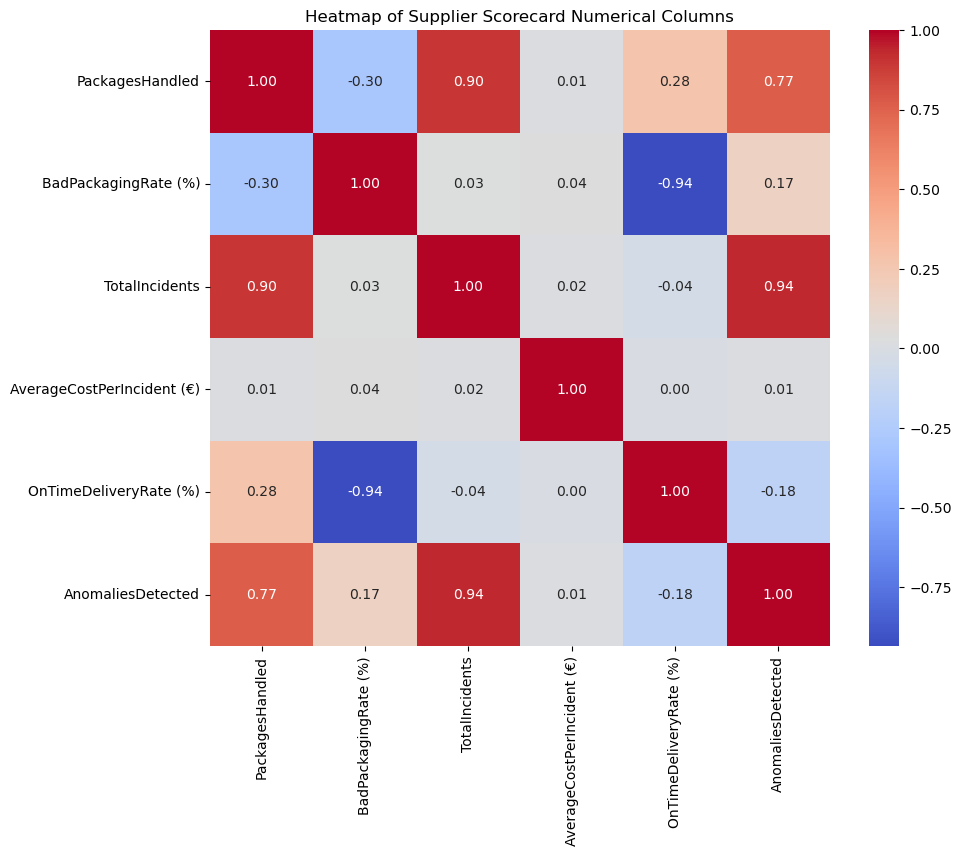

In [127]:
supplier_scorecard_numerical_cols = ['PackagesHandled', 'BadPackagingRate (%)', 'TotalIncidents', 'AverageCostPerIncident (€)', 'OnTimeDeliveryRate (%)', 'AnomaliesDetected']

supplier_scorecard_numeric = supplier_scorecard[supplier_scorecard_numerical_cols]

correlation_matrix = supplier_scorecard_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Supplier Scorecard Numerical Columns')
plt.show()